In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import wandb

#### Data Preprocessing

In [3]:
df = pd.read_csv('WineQT.csv')
df = df.drop(columns=['Id'])

X = df.drop(columns=['quality'])  # Features
y = df['quality']  # Labels

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')
X = imputer.fit_transform(X)

# Normalize the data using MinMaxScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# one hot encode y
y = np.eye(np.unique(y).shape[0])[y]

# Split the data into training, validation, and test sets
# 70% for training, 15% for validation, and 15% for testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)

X_train shape:  (800, 11)
y_train shape:  (800, 6)


### Task 2.1 MLP Classifier Model

In [4]:
class MlpClassifier:
  def __init__(
    self,
    inputLayerSize=13, 
    hiddenLayers=[4, 3], 
    outputLayerSize=1, 
    activation='relu', 
    learningRate=0.01,
    optimizer='mini-batch',
    batchSize=64, 
    iterations=100000
  ):
    self.inputLayerSize = inputLayerSize
    self.hiddenLayers = hiddenLayers
    self.outputLayerSize = outputLayerSize
    self.activation = activation
    self.learningRate = learningRate
    self.optimizer = optimizer
    self.batchSize = batchSize
    self.iterations = iterations
    
    self.weights = self.initializeWeights()
    
  def softmax(self, X):
    exp_X = np.exp(X - np.max(X, axis=1, keepdims=True))
    return exp_X / np.sum(exp_X, axis=1, keepdims=True)

  def initializeWeights(self):
    layerSizes = [self.inputLayerSize] + self.hiddenLayers + [self.outputLayerSize]
    weights = [np.random.randn(layerSizes[i - 1], layerSizes[i]) / np.sqrt(layerSizes[i - 1]) for i in range(1, len(layerSizes))]
    return weights

  def activate(self, z):
    if self.activation == 'sigmoid':
      return 1 / (1 + np.exp(-z))
    elif self.activation == 'tanh':
      return np.tanh(z)
    elif self.activation == 'relu':
      return np.maximum(0, z)

  def activateDerivative(self, z):
    if self.activation == 'sigmoid':
      return self.activate(z) * (1 - self.activate(z))
    elif self.activation == 'tanh':
      return 1 - np.tanh(z) ** 2
    elif self.activation == 'relu':
      return np.where(z <= 0, 0, 1)
    
  def costFunction(self, X, y):
    yHat = self.forward(X)[0][-1]
    # cross entropy loss
    # print(y.shape, yHat.shape)
    loss = -np.mean(y * np.log(yHat))
    return loss

  def forward(self, X):
    activations = [X]
    zValues = []
    layerInput = X
    for i in range(len(self.weights) - 1):
      z = np.dot(layerInput, self.weights[i])
      layerOutput = self.activate(z)
      activations.append(layerOutput)
      zValues.append(z)
      layerInput = layerOutput

    # Output layer with softmax activation
    output_layer = np.dot(layerInput, self.weights[-1])
    output_activation = self.softmax(output_layer)
    activations.append(output_activation)
    zValues.append(output_layer)

    return activations, zValues

  def backward(self, X, y, activations, zValues):
    m = X.shape[0]  # number of samples
    gradientsW = [np.zeros_like(weight) for weight in self.weights]

    # Compute gradients for the output layer with softmax activation and cross-entropy loss
    delta = activations[-1] - y
    gradientsW[-1] = np.dot(activations[-2].T, delta) / m

    # Backpropagate the error to compute gradients for hidden layers
    for i in range(len(self.weights) - 2, -1, -1):
      delta = np.dot(delta, self.weights[i + 1].T) * self.activateDerivative(zValues[i])
      gradientsW[i] = np.dot(activations[i].T, delta) / m

    return gradientsW

  def computeGradients(self, X, y):
    activations, zValues = self.forward(X)
    gradientsW = self.backward(X, y, activations, zValues)
    return gradientsW
  
  def getMiniBatches(self, X, y, batch_size):
    num_samples = X.shape[0]
    num_batches = num_samples // batch_size
    mini_batches = []

    # Shuffle the data before creating mini-batches
    indices = np.random.permutation(num_samples)
    X_shuffled = X[indices]
    y_shuffled = y[indices]

    for i in range(num_batches):
      start_idx = i * batch_size
      end_idx = (i + 1) * batch_size
      mini_batch_X = X_shuffled[start_idx:end_idx]
      mini_batch_y = y_shuffled[start_idx:end_idx]
      mini_batches.append((mini_batch_X, mini_batch_y))

    # If there are remaining samples, create one more mini-batch
    if num_samples % batch_size != 0:
      mini_batch_X = X_shuffled[num_batches * batch_size:]
      mini_batch_y = y_shuffled[num_batches * batch_size:]
      mini_batches.append((mini_batch_X, mini_batch_y))

    return mini_batches

  def updateWeights(self, gradientsW):
    for i in range(len(self.weights)):
      self.weights[i] -= self.learningRate * gradientsW[i]
      
  def predict(self, X):
    return label_encoder.inverse_transform(np.argmax(self.forward(X)[0][-1], axis=1))
  
  def get_accuracy(self, X, y):
    y_pred = self.predict(X)
    return np.mean(y_pred == label_encoder.inverse_transform(np.argmax(y, axis=1)))


In [5]:
class Trainer(object):
  def __init__(self, N):
    # Make Local reference to network:
    self.N = N
    
  def sgd(self, X, y):
    k = 0
    for i in range(len(X)):
      x_sgd = X[i].reshape(1, -1)
      y_sgd = y[i].reshape(1, -1)
      grad = self.N.computeGradients(x_sgd, y_sgd)
      self.N.updateWeights(grad)
      k += 1
    return k

  def miniBatch(self, X, y, batch_size):
    k = 0
    mini_batches = self.N.getMiniBatches(X, y, batch_size=batch_size)
    for x_mini, y_mini in mini_batches:
      grad = self.N.computeGradients(x_mini, y_mini)
      self.N.updateWeights(grad)
      k += 1
    return k
  
  def batch(self, X, y):
    grad = self.N.computeGradients(X, y)
    self.N.updateWeights(grad)
    return 1
  
  def optimiser(self, X, y):
    if self.N.optimizer == 'sgd':
      return self.sgd(X, y)
    elif self.N.optimizer == 'mini-batch':
      return self.miniBatch(X, y, self.N.batchSize)
    elif self.N.optimizer == 'batch':
      return self.batch(X, y)
    
  def getMetrics(self, X, y_true):
    y_true_label = label_encoder.inverse_transform(np.argmax(y_true, axis=1))
    y_pred = self.predict(X)
    print('--'*50)
    print(classification_report(y_true_label, y_pred, zero_division=0))
    print('--'*50)
    accuracy = self.N.get_accuracy(X, y_true)
    loss = self.N.costFunction(X, y_true)
    f1 = f1_score(y_true_label, y_pred, average='macro', zero_division=0)
    precision = precision_score(y_true_label, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true_label, y_pred, average='macro', zero_division=0)
    print("Accuracy: %f - Loss: %f - F1: %f - Precision: %f - Recall: %f" % (accuracy, loss, f1, precision, recall))
    return loss, accuracy, f1, precision, recall
  
  def predict(self, X):
    return self.N.predict(X)

  def train(self, X, y):
    #Make an internal variable for the callback function:
    self.X = X
    self.y = y

    #Make empty list to store costs:
    self.J = []

    loss = self.N.costFunction(X, y)
    k = 0
    maxiter = self.N.iterations

    while (loss > 1e-5) and (k < maxiter):
      k += self.optimiser(X, y)
      loss = self.N.costFunction(X, y)
      self.J.append(loss)
      if k % X.shape[0] == 0:
        print("Iteration %d: loss = %f - Accuracy (Train): %f" % (k, loss, self.N.get_accuracy(X, y)))

    print("Operation terminated successfully.")
    print("         Iterations: %d" % k)
    print("         Final loss function: %f" % loss)

In [6]:
mlp = MlpClassifier(
  inputLayerSize=X_train.shape[1],
  hiddenLayers=[9, 7],
  outputLayerSize=y_train.shape[1],
  activation='sigmoid',
  learningRate=0.01,
  optimizer='mini-batch'
)
T = Trainer(mlp)
T.train(X_train, y_train)

T.getMetrics(X_train, y_train)

Iteration 10400: loss = 0.166168 - Accuracy (Train): 0.601250
Iteration 20800: loss = 0.158687 - Accuracy (Train): 0.621250
Iteration 31200: loss = 0.154879 - Accuracy (Train): 0.622500
Iteration 41600: loss = 0.152218 - Accuracy (Train): 0.632500
Iteration 52000: loss = 0.150232 - Accuracy (Train): 0.633750
Iteration 62400: loss = 0.148660 - Accuracy (Train): 0.636250
Iteration 72800: loss = 0.147343 - Accuracy (Train): 0.642500
Iteration 83200: loss = 0.146201 - Accuracy (Train): 0.642500
Iteration 93600: loss = 0.145191 - Accuracy (Train): 0.647500
Operation terminated successfully.
         Iterations: 100009
         Final loss function: 0.144628
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00        24
           5       0.69      0.79      0.74       340
           6       0.6

(0.1446283342298554,
 0.65125,
 0.31820092230837427,
 0.31794871794871793,
 0.32117150657731447)

----------------------------------------------------------------------------------------------------
Loss for the validation set: 0.13802106954872204
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Classification Report on Validation Set:
              precision    recall  f1-score   support

           4       0.00      0.00      0.00         0
           5       0.81      0.65      0.72        77
           6       0.63      0.67      0.65        76
           7       0.46      0.61      0.52        18
           8       0.00      0.00      0.00         0

    accuracy                           0.65       171
   macro avg       0.38      0.39      0.38       171
weighted avg       0.69      0.65      0.67       171

----------------------------------------------------------------------------------------------------


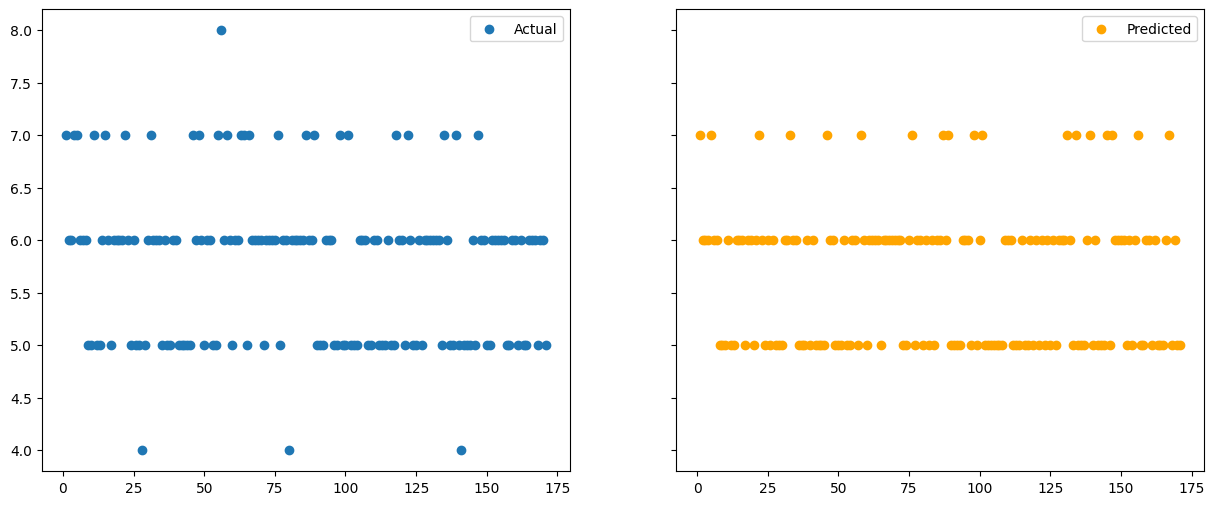

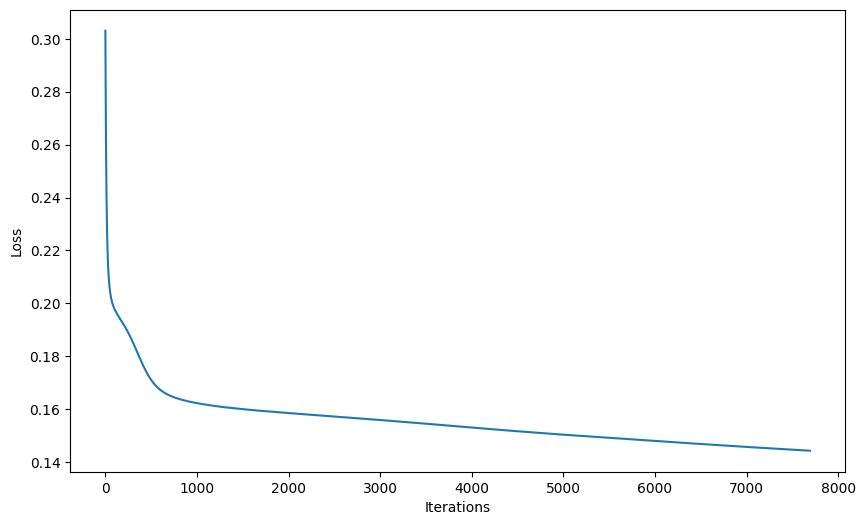

In [347]:
y_pred_val = mlp.predict(X_val)
mlp_cost = mlp.costFunction(X_val, y_val)
y_orig_val = label_encoder.inverse_transform(np.argmax(y_val, axis=1))

print('--'*50)
print('Loss for the validation set:', mlp_cost)
print('--'*50)

print('--'*50)
print('Classification Report on Validation Set:')
print(classification_report(y_pred_val, y_orig_val, zero_division=0))
print('--'*50)

# create two subplots with shared y axis using plt.subplots

plt.subplots(1, 2, sharey=True, figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.scatter([i for i in range(1,len(y_orig_val)+1)], y_orig_val, label='Actual')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter([i for i in range(1,len(y_orig_val)+1)], y_pred_val, label='Predicted', color='orange')
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(T.J)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

### Task 2.2 Hyperparameter Tuning

In [ ]:
sweep_config = {
  'method': 'grid',
  'metric': {
    'name': 'accuracy',
    'goal': 'maximize'
  },
  'parameters': {
    'learning_rates': {'values': [0.001, 0.01]},
    'iterations': {'values': [25000, 100000]},
    'optimizer': {'values': ['sgd', 'mini-batch', 'batch']},
    'batchSize': {'values': [32, 64]},
    'activation': {'values': ['sigmoid', 'tanh', 'relu']},
    'hiddenLayers': {'values': [[4, 7], [9, 7]]}
  }
}

sweep_id = wandb.sweep(sweep=sweep_config, project="Multilayer-Perceptron-Classifier-Wine-Quality")

# Define sweep function
def sweep_function():
  with wandb.init(config=sweep_config):
    optimizer = wandb.config.optimizer
    batchSize = wandb.config.batchSize
    activation = wandb.config.activation
    iterations = wandb.config.iterations
    hiddenLayers = wandb.config.hiddenLayers
    learning_rate = wandb.config.learning_rates
    
    mlp = MlpClassifier(
      inputLayerSize=X_train.shape[1],
      hiddenLayers=hiddenLayers,
      outputLayerSize=y_train.shape[1],
      activation=activation,
      learningRate=learning_rate,
      optimizer=optimizer,
      batchSize=batchSize,
      iterations=iterations
    )
    
    T = Trainer(mlp)
    T.train(X_train, y_train)
    
    print('Metrics on Train Set:')
    print('--'*50)
    T.getMetrics(X_train, y_train)
    print('--'*50)
    
    print('Metrics on Validation Set:')
    print('--'*50)
    metrics = T.getMetrics(X_val, y_val)
    print('--'*50)
    
    # Log hyperparameters and validation loss
    wandb.log({
      'learning_rate': learning_rate,
      'iterations': iterations,
      'optimizer': optimizer,
      'batchSize': batchSize,
      'activation': activation,
      'hiddenLayers': hiddenLayers,
      'validation_loss': metrics[0],
      'accuracy': metrics[1],
      'f1_score': metrics[2],
      'precision': metrics[3],
      'recall': metrics[4]
    })
    
wandb.agent(sweep_id, function=sweep_function)


#### wandb logging is completed

In [352]:
api = wandb.Api()

best_run = api.sweep("chnaveenin/Multilayer-Perceptron-Classifier-Wine-Quality/sweeps/"+sweep_id).best_run()
print('Results for best run:')
print('--'*50)
print(
  'epochs:', best_run.config['iterations'], '\n'
  'learning_rate:', best_run.config['learning_rates'], '\n'
  'hidden_layers:', best_run.config['hiddenLayers'], '\n'
  'activation:', best_run.config['activation'], '\n'
  'optimizer:', best_run.config['optimizer'], '\n'
  'batch_size:', best_run.config['batchSize'], '\n'
  'validation_accuracy:', best_run.summary['accuracy'], '\n'
  'validation_loss:', best_run.summary['validation_loss'], '\n'
  'f1_score:', best_run.summary['f1_score'], '\n'
  'precision:', best_run.summary['precision'], '\n'
  'recall:', best_run.summary['recall']
)
print('--'*50)

wandb: Sorting runs by -summary_metrics.accuracy


Results for best run:
----------------------------------------------------------------------------------------------------
epochs: 100000 
learning_rate: 0.01 
hidden_layers: [9, 7] 
activation: relu 
optimizer: batch 
batch_size: 64 
validation_accuracy: 0.6549707602339181 
validation_loss: 0.2102669865426385 
f1_score: 0.3178462874511507 
precision: 0.31547372458764866 
recall: 0.3261399840700916
----------------------------------------------------------------------------------------------------


### Task 2.3 Evaluating Model

In [353]:
mlp = MlpClassifier(
  inputLayerSize=X_test.shape[1],
  hiddenLayers=best_run.config['hiddenLayers'],
  outputLayerSize=y_test.shape[1],
  activation=best_run.config['activation'],
  learningRate=best_run.config['learning_rates'],
  optimizer=best_run.config['optimizer'],
  batchSize=best_run.config['batchSize'],
  iterations=best_run.config['iterations']
)

T = Trainer(mlp)
T.train(X_train, y_train)

T.getMetrics(X_test, y_test)

Iteration 800: loss = 0.181032 - Accuracy (Train): 0.570000
Iteration 1600: loss = 0.167072 - Accuracy (Train): 0.588750
Iteration 2400: loss = 0.162187 - Accuracy (Train): 0.603750
Iteration 3200: loss = 0.159002 - Accuracy (Train): 0.611250
Iteration 4000: loss = 0.156565 - Accuracy (Train): 0.608750
Iteration 4800: loss = 0.154706 - Accuracy (Train): 0.612500
Iteration 5600: loss = 0.153191 - Accuracy (Train): 0.628750
Iteration 6400: loss = 0.151887 - Accuracy (Train): 0.645000
Iteration 7200: loss = 0.150754 - Accuracy (Train): 0.640000
Iteration 8000: loss = 0.149824 - Accuracy (Train): 0.645000
Iteration 8800: loss = 0.148994 - Accuracy (Train): 0.647500
Iteration 9600: loss = 0.148298 - Accuracy (Train): 0.643750
Iteration 10400: loss = 0.147679 - Accuracy (Train): 0.640000
Iteration 11200: loss = 0.147071 - Accuracy (Train): 0.637500
Iteration 12000: loss = 0.146520 - Accuracy (Train): 0.638750
Iteration 12800: loss = 0.145978 - Accuracy (Train): 0.638750
Iteration 13600: loss

(0.23326288473287518,
 0.5465116279069767,
 0.30830110733199767,
 0.2958211143695014,
 0.3240891570303335)

In [355]:
y_pred_test = T.predict(X_test)
print('--'*50)
print('Classification Report on Test Set:')
print(classification_report(y_pred_test, label_encoder.inverse_transform(np.argmax(y_test, axis=1)), zero_division=0))
print('--'*50)

----------------------------------------------------------------------------------------------------
Classification Report on Test Set:
              precision    recall  f1-score   support

           4       0.00      0.00      0.00         0
           5       0.70      0.65      0.67        88
           6       0.45      0.47      0.46        62
           7       0.47      0.36      0.41        22
           8       0.00      0.00      0.00         0

    accuracy                           0.55       172
   macro avg       0.32      0.30      0.31       172
weighted avg       0.58      0.55      0.56       172

----------------------------------------------------------------------------------------------------


### Task 2.4 Multi-Label Classification

#### Data Preprocessing

In [6]:

data_multi = pd.read_csv('advertisement.csv')
X_multi = data_multi.drop(['labels'], axis=1)
y_multi = data_multi['labels']

features = ['gender', 'education', 'married', 'city', 'occupation', 'most bought item']
X_multi = pd.get_dummies(X_multi, columns=features)

# standardize data other than these features
scaler = StandardScaler()
X_multi[['age', 'income', 'children', 'purchase_amount']] = scaler.fit_transform(X_multi[['age', 'income', 'children', 'purchase_amount']])
X_multi = X_multi.to_numpy()

X_multi_train, X_multi_temp, y_multi_train, y_multi_temp = train_test_split(X_multi, y_multi, test_size=0.3, random_state=42)
X_multi_val, X_multi_test, y_multi_val, y_multi_test = train_test_split(X_multi_temp, y_multi_temp, test_size=0.5, random_state=42)


#### MultiLabel MLP Classifier

In [7]:
class MultiLabelMlpClassifier(MlpClassifier):
  def sigmoid(self, z):
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))
  
  def costFunction(self, X, y):
    yHat = self.forward(X)[0][-1]
    # binary cross entropy loss
    loss = -np.mean(y * np.log(yHat) + (1-y) * np.log(1-yHat))
    return loss
  
  def forward(self, X):
    activations = [X]
    zValues = []
    layerInput = X
    for i in range(len(self.weights) - 1):
      z = np.dot(layerInput, self.weights[i])
      layerOutput = self.activate(z)
      activations.append(layerOutput)
      zValues.append(z)
      layerInput = layerOutput

    output_layer = np.dot(layerInput, self.weights[-1])
    output_activation = self.sigmoid(output_layer)
    activations.append(output_activation)
    zValues.append(output_layer)
    
    return activations, zValues
  
  def predict(self, X):
    yHat = self.forward(X)[0][-1]
    return yHat

In [69]:
from sklearn.metrics import roc_curve, jaccard_score

class Trainer_multi(Trainer):
  def __init__(self, N):
    super().__init__(N)
    self.threshold = [0.5]*self.N.outputLayerSize
    self.map = []
    
  def convert_to_scores(self, y_multi_labels):
    y_multi_scores = []
    unique_labels = sorted({label for elem in y_multi_labels for label in elem.split(' ')})
    self.map = unique_labels
    for yy in y_multi_labels:
      y_multi_scores.append([1 if label in yy.split(' ') else 0 for label in unique_labels])
      
    return np.array(y_multi_scores)
  
  def train(self, X, y_true_scores):
    self.J = []
    loss = self.N.costFunction(X, y_true_scores)
    k = 0
    maxiter = self.N.iterations

    while (loss > 1e-5) and (k < maxiter):
      k += self.optimiser(X, y_true_scores)
      loss = self.N.costFunction(X, y_true_scores)
      self.J.append(loss)
      y_pred_multi_scores = self.N.predict(X)

      for i in range(len(self.map)):
        fpr, tpr, thresholds = roc_curve(y_true_scores[:,i], y_pred_multi_scores[:, i])
        self.threshold[i] = thresholds[np.argmax(tpr - fpr)]
  
      if k % 100 == 0:
        metrics = self.getMetrics(X, y_true_scores)
        print("Iteration %d: loss = %f - Accuracy (Train): %f - Jaccard (Train): %f" % (k, loss, metrics[1], metrics[5]))

    metrics = self.getMetrics(X, y_true_scores)
    print("Operation terminated successfully.")
    print("         Iterations: %d" % k)
    print("         Final loss function: %f" % loss)
    print("         Final Jaccard_score: %f" % metrics[5])
    print("         Final Accuracy: %f" % metrics[1])
    
    # plot loss function
    plt.figure(figsize=(10, 6))
    plt.plot(self.J)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.show()
    
  def hammingloss(self, y_test_one_hot, y_pred_one_hot):
    return np.sum(np.abs(y_test_one_hot - y_pred_one_hot))/(y_pred_one_hot.shape[0]*y_pred_one_hot.shape[1])
    
  def getMetrics(self, X, y_true_scores):
    y_pred_scores = self.predict(X)
    y_pred_labels = self.convert_to_labels(y_pred_scores)
    y_true_labels = self.convert_to_labels(y_true_scores)
    y_pred_scores_binary = np.where(y_pred_scores >= self.threshold, 1, 0)
    
    accuracy = 1 - self.hammingloss(y_true_scores, y_pred_scores_binary)
    loss = self.N.costFunction(X, y_true_scores)
    f1 = f1_score(y_true_labels, y_pred_labels, average='macro', zero_division=0)
    precision = precision_score(y_true_labels, y_pred_labels, average='macro', zero_division=0)
    recall = recall_score(y_true_labels, y_pred_labels, average='macro', zero_division=0)
    jaccard = jaccard_score(y_true_scores, y_pred_scores_binary, average='macro', zero_division=0)
    print("Accuracy: %f - Loss: %f - F1: %f - Precision: %f - Recall: %f" % (accuracy, loss, f1, precision, recall))
    return loss, accuracy, f1, precision, recall, jaccard
    
  def convert_to_labels(self, y_pred_scores):
    y_pred_labels = []
    for y in y_pred_scores:
      y_pred_labels.append([self.map[i] for i in range(len(y)) if y[i] >= self.threshold[i]])
    for i in range(len(y_pred_labels)):
      if len(y_pred_labels[i]) == 0:
        y_pred_labels[i] = 'None'
      else:
        y_pred_labels[i] = ' '.join(y_pred_labels[i])
    return np.array(y_pred_labels, dtype=object)
    
  def predict(self, X):
    yHat_scores = self.N.predict(X)
    return yHat_scores
  
  def predict_bin(self, X):
    yHat_scores = self.N.predict(X)
    return np.where(yHat_scores >= self.threshold, 1, 0)
      

#### Training the model

Accuracy: 0.502679 - Loss: 0.694637 - F1: 0.000000 - Precision: 0.000000 - Recall: 0.000000
Iteration 100: loss = 0.694637 - Accuracy (Train): 0.502679 - Jaccard (Train): 0.283224
Accuracy: 0.540893 - Loss: 0.692652 - F1: 0.001194 - Precision: 0.005173 - Recall: 0.003354
Iteration 200: loss = 0.692652 - Accuracy (Train): 0.540893 - Jaccard (Train): 0.279582
Accuracy: 0.540179 - Loss: 0.690978 - F1: 0.001114 - Precision: 0.002616 - Recall: 0.003257
Iteration 300: loss = 0.690978 - Accuracy (Train): 0.540179 - Jaccard (Train): 0.289961
Accuracy: 0.540714 - Loss: 0.689510 - F1: 0.000350 - Precision: 0.000189 - Recall: 0.002752
Iteration 400: loss = 0.689510 - Accuracy (Train): 0.540714 - Jaccard (Train): 0.304674
Accuracy: 0.545179 - Loss: 0.688184 - F1: 0.000548 - Precision: 0.000295 - Recall: 0.003931
Iteration 500: loss = 0.688184 - Accuracy (Train): 0.545179 - Jaccard (Train): 0.310169
Accuracy: 0.562143 - Loss: 0.686959 - F1: 0.002014 - Precision: 0.001547 - Recall: 0.005977
Iteratio

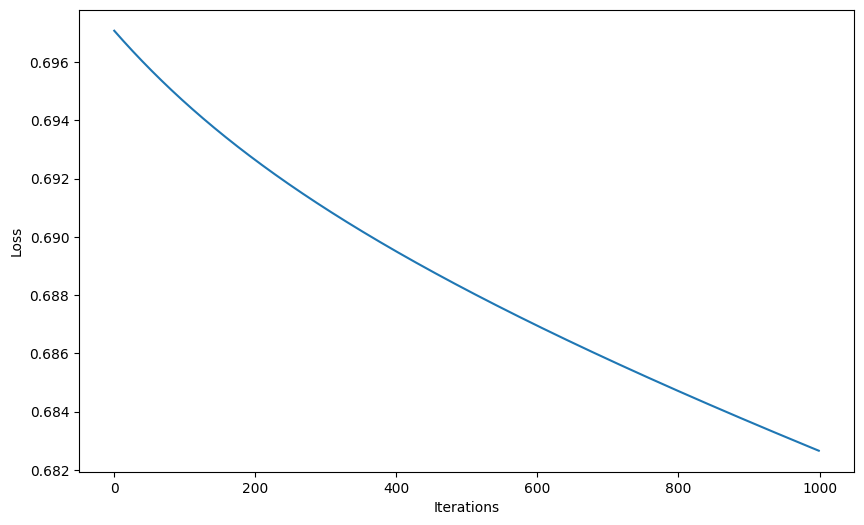

Accuracy: 0.553333 - Loss: 0.684020 - F1: 0.000000 - Precision: 0.000000 - Recall: 0.000000
(0.6840197302794331, 0.5533333333333333, 0.0, 0.0, 0.0, 0.2489253732034921)
Accuracy: 0.560000 - Loss: 0.687346 - F1: 0.004540 - Precision: 0.002732 - Recall: 0.016393
(0.6873457768730398, 0.56, 0.004539722572509458, 0.00273224043715847, 0.01639344262295082, 0.2685088274618681)


In [70]:
y_dim = len(sorted({label for elem in y_multi_train for label in elem.split(' ')}))

mlp_multi = MultiLabelMlpClassifier(
  inputLayerSize=X_multi_train.shape[1],
  hiddenLayers=[9,7],
  outputLayerSize=y_dim,
  activation='tanh',
  learningRate=0.001,
  optimizer='batch',
  iterations=1000
)

T_multi = Trainer_multi(mlp_multi)

y_multi_train_scores = T_multi.convert_to_scores(y_multi_train)
T_multi.train(X_multi_train, y_multi_train_scores)

y_multi_val_scores = T_multi.convert_to_scores(y_multi_val)
print(T_multi.getMetrics(X_multi_val, y_multi_val_scores))

y_multi_test_scores = T_multi.convert_to_scores(y_multi_test)
print(T_multi.getMetrics(X_multi_test, y_multi_test_scores))

#### Hyperparameter Tuning

In [ ]:
sweep_config = {
  'method': 'grid',
  'metric': {
    'name': 'accuracy',
    'goal': 'maximize'
  },
  'parameters': {
    'learning_rates': {'values': [0.001, 0.005]},
    'iterations': {'values': [25000, 10000]},
    'optimizer': {'values': ['sgd', 'mini-batch', 'batch']},
    'batchSize': {'values': [32, 64]},
    'activation': {'values': ['sigmoid', 'tanh', 'relu']},
    'hiddenLayers': {'values': [[4, 7], [9, 7]]}
  }
}

sweep_id = wandb.sweep(sweep=sweep_config, project="Multilayer-Perceptron-Classifier-Multi-Label-Advertisement-v2")

# Define sweep function
def sweep_function():
  with wandb.init(config=sweep_config):
    optimizer = wandb.config.optimizer
    batchSize = wandb.config.batchSize
    activation = wandb.config.activation
    iterations = wandb.config.iterations
    hiddenLayers = wandb.config.hiddenLayers
    learning_rate = wandb.config.learning_rates
    
    mlp_multi_tune = MultiLabelMlpClassifier(
      inputLayerSize=X_multi_train.shape[1],
      hiddenLayers=hiddenLayers,
      outputLayerSize=y_dim,
      activation=activation,
      learningRate=learning_rate,
      optimizer=optimizer,
      batchSize=batchSize,
      iterations=iterations
    )
    
    T_multi_tune = Trainer_multi(mlp_multi_tune)
    y_multi_train_scores = T_multi_tune.convert_to_scores(y_multi_train)
    T_multi_tune.train(X_multi_train, y_multi_train_scores)
    
    print('Metrics on Validation Set:')
    print('--'*50)
    y_multi_val_scores = T_multi_tune.convert_to_scores(y_multi_val)
    metrics = T_multi_tune.getMetrics(X_multi_val, y_multi_val_scores)
    print('--'*50)
    
    # Log hyperparameters and validation loss
    wandb.log({
      'learning_rate': learning_rate,
      'iterations': iterations,
      'optimizer': optimizer,
      'batchSize': batchSize,
      'activation': activation,
      'hiddenLayers': hiddenLayers,
      'validation_loss': metrics[0],
      'accuracy': 1 - T_multi_tune.hammingloss(y_multi_val_scores, T_multi_tune.predict_bin(X_multi_val)),
      'f1_score': metrics[2],
      'precision': metrics[3],
      'recall': metrics[4]
    })
    
wandb.agent(sweep_id, function=sweep_function)

### wandb logging is completed

In [63]:
api = wandb.Api()

runs = list(api.sweep("chnaveenin/Multilayer-Perceptron-Classifier-Multi-Label-Advertisement-v2/sweeps/"+sweep_id).runs)

acc_scores = []
for run in runs:
  acc_scores.append(run.summary['accuracy'])
best_run = runs[np.argmax(acc_scores)]

print('Results for best run:')
print('--'*50)
print(
  'epochs:', best_run.config['iterations'], '\n'
  'learning_rate:', best_run.config['learning_rates'], '\n'
  'hidden_layers:', best_run.config['hiddenLayers'], '\n'
  'activation:', best_run.config['activation'], '\n'
  'optimizer:', best_run.config['optimizer'], '\n'
  'batch_size:', best_run.config['batchSize'], '\n'
  'validation_accuracy:', best_run.summary['accuracy'], '\n'
  'validation_loss:', best_run.summary['validation_loss'], '\n'
  'f1_score:', best_run.summary['f1_score'], '\n'
  'precision:', best_run.summary['precision'], '\n'
  'recall:', best_run.summary['recall'],
)
print('--'*50)

Results for best run:
----------------------------------------------------------------------------------------------------
epochs: 25000 
learning_rate: 0.005 
hidden_layers: [9, 7] 
activation: tanh 
optimizer: batch 
batch_size: 32 
validation_accuracy: 0.7683333333333333 
validation_loss: 0.6798832423047916 
f1_score: 0.02238850330955594 
precision: 0.014562201143083497 
recall: 0.06006944444444443
----------------------------------------------------------------------------------------------------


Accuracy: 0.550714 - Loss: 0.676687 - F1: 0.005993 - Precision: 0.006623 - Recall: 0.015459
Iteration 100: loss = 0.676687 - Accuracy (Train): 0.550714 - Jaccard (Train): 0.285332
Accuracy: 0.543214 - Loss: 0.666073 - F1: 0.002866 - Precision: 0.002039 - Recall: 0.007716
Iteration 200: loss = 0.666073 - Accuracy (Train): 0.543214 - Jaccard (Train): 0.314976
Accuracy: 0.580179 - Loss: 0.657019 - F1: 0.002839 - Precision: 0.002867 - Recall: 0.015638
Iteration 300: loss = 0.657019 - Accuracy (Train): 0.580179 - Jaccard (Train): 0.317555
Accuracy: 0.593036 - Loss: 0.650049 - F1: 0.001817 - Precision: 0.001953 - Recall: 0.011798
Iteration 400: loss = 0.650049 - Accuracy (Train): 0.593036 - Jaccard (Train): 0.322747
Accuracy: 0.610714 - Loss: 0.645055 - F1: 0.003417 - Precision: 0.002769 - Recall: 0.012567
Iteration 500: loss = 0.645055 - Accuracy (Train): 0.610714 - Jaccard (Train): 0.321941
Accuracy: 0.609107 - Loss: 0.641498 - F1: 0.004788 - Precision: 0.004858 - Recall: 0.013672
Iteratio

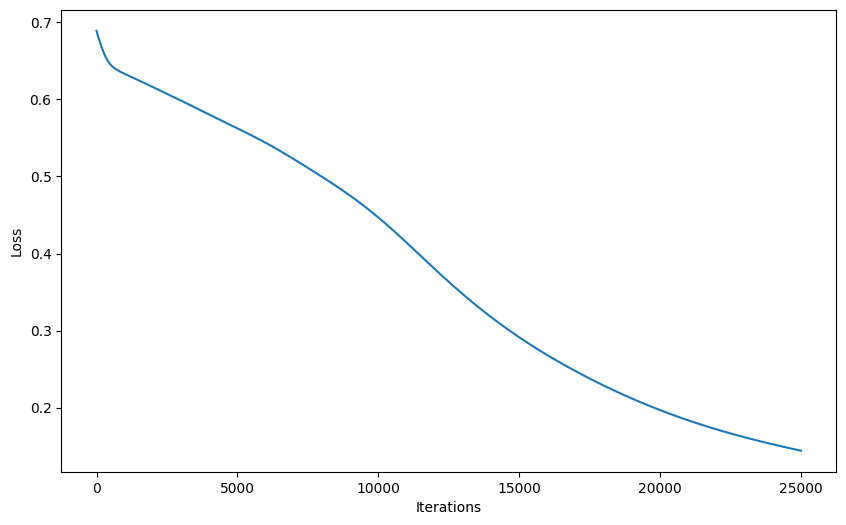

Metrics on Validation Set:
Accuracy: 0.752500 - Loss: 0.648807 - F1: 0.015424 - Precision: 0.009954 - Recall: 0.042535
Metrics on Test Set:
Accuracy: 0.736667 - Loss: 0.711737 - F1: 0.021137 - Precision: 0.018809 - Recall: 0.043030


In [71]:
mlp_multi_best = MultiLabelMlpClassifier(
  inputLayerSize=X_multi_train.shape[1],
  hiddenLayers=best_run.config['hiddenLayers'],
  outputLayerSize=y_dim,
  activation=best_run.config['activation'],
  learningRate=best_run.config['learning_rates'],
  optimizer=best_run.config['optimizer'],
  batchSize=best_run.config['batchSize'],
  iterations=best_run.config['iterations']
)

T_multi_best = Trainer_multi(mlp_multi_best)

y_multi_train_scores = T_multi_best.convert_to_scores(y_multi_train)
T_multi_best.train(X_multi_train, y_multi_train_scores)

print('Metrics on Validation Set:')
y_multi_val_scores = T_multi_best.convert_to_scores(y_multi_val)
T_multi_best.getMetrics(X_multi_val, y_multi_val_scores)

print('Metrics on Test Set:')
y_multi_test_scores = T_multi_best.convert_to_scores(y_multi_test)
mcmcm = T_multi_best.getMetrics(X_multi_test, y_multi_test_scores)